# WEkEO – Crop Status - JN02 (data processing)

### Load required libraries

In [1]:
import os
import rasterio as rio
from rasterio import plot
from rasterio.mask import mask
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.plot import show
from rasterio.plot import plotting_extent
import zipfile
from matplotlib import rcParams
from pathlib import Path
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML



### Load Sentinel-2 bands and True Color image at 10 meters resolution

In [2]:
#Download folder
download_dir_path = os.path.join(os.getcwd(), 'data/from_wekeo')
data_path = os.path.join(os.getcwd(), 'data')

R10 =  os.path.join(download_dir_path, 'S2A_MSIL2A_20170802T101031_N0205_R022_T32TNN_20170802T101051.SAFE/GRANULE/L2A_T32TNN_A011030_20170802T101051/IMG_DATA/R10m') #10 meters resolution folder
b4 = rio.open(R10+'/L2A_T32TNN_20170802T101031_B04_10m.jp2') #red
b3 = rio.open(R10+'/L2A_T32TNN_20170802T101031_B03_10m.jp2') #green
b2 = rio.open(R10+'/L2A_T32TNN_20170802T101031_B02_10m.jp2') #blue
b8 = rio.open(R10+'/L2A_T32TNN_20170802T101031_B08_10m.jp2') #near infrared 
TCI =  rio.open(R10+'/L2A_T32TNN_20170802T101031_TCI_10m.jp2') #true color

### Display True Color image

Text(0.5, 0, 'Easting (m)')

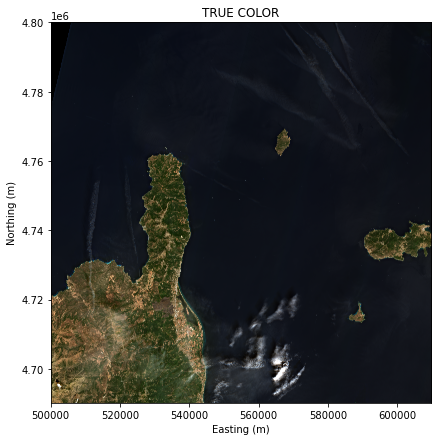

In [3]:
fig, ax = plt.subplots(1, figsize=(21,7))
ax.set_title("TRUE COLOR")
show(TCI.read(), ax=ax, transform=TCI.transform)
ax.set_ylabel("Northing (m)") # (WGS 84 / UTM zone 32N)
ax.set_xlabel("Easting (m)")

### Open Vector Data

In [4]:
path_shp  = os.path.join(os.getcwd(), 'shp')
aoi = gpd.read_file(os.path.join(path_shp, 'WEkEO-Land-AOI-201223.shp'))
LPSI = gpd.read_file(os.path.join(path_shp, 'LPIS-AOI-201223.shp'))

### Check CRS of Vector Data

In [5]:
print(aoi.crs)
print(LPSI.crs)
aoi_proj = aoi.to_crs(epsg=32632) #convert to WGS 84 / UTM zone 32N (Sentinel-2 crs)
LPIS_proj = LPSI.to_crs(epsg=32632)
print("new crs:")
print(aoi_proj.crs)
print(LPIS_proj.crs)

epsg:4326
epsg:2154
new crs:
epsg:32632
epsg:32632


### Calculate NDVI index from red and near infrared bands

In [6]:
nir = b8.read()
red = b4.read()
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

meta = b4.meta 
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)
with rio.open(os.path.join(data_path, 'S2_NDVI.tif'), 'w', **meta) as dst:
    dst.write(ndvi.astype(rio.float32))

##### Crop the extent of the NDVI image to the area of interest (AOI)

In [7]:
with rio.open(os.path.join(data_path, "S2_NDVI.tif")) as src:
    out_image, out_transform = mask(src, aoi_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open(os.path.join(data_path, "S2_NDVI_masked.tif"), "w", **out_meta) as dest:
    dest.write(out_image)   

### Overlay LPIS and display

Text(0.5, 42.0, 'Easting (m)')

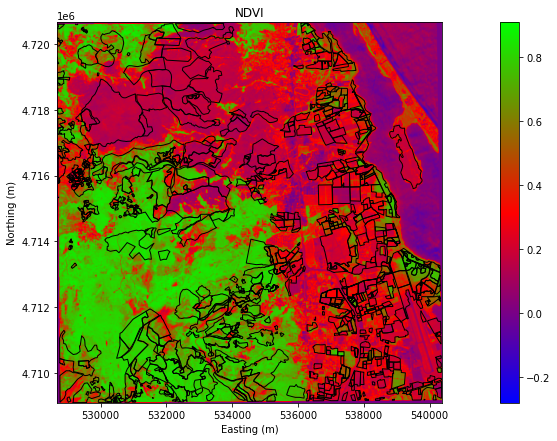

In [8]:
ndvi_aoi = rio.open(os.path.join(data_path, 'S2_NDVI_masked.tif'))

fig, ax = plt.subplots(figsize=(21, 7))

# use imshow so that we have something to map the colorbar to
image_hidden_1 = ax.imshow(ndvi_aoi.read(1), 
                         cmap='brg')

LPIS_proj.plot(ax=ax, facecolor='none', edgecolor='k')

image = show(ndvi_aoi, ax=ax, cmap='brg', transform=ndvi_aoi.transform)
ax.set(title="NDVI")

fig.colorbar(image_hidden_1, ax=ax)
ax.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
ax.set_xlabel("Easting (m)")

### Histogram

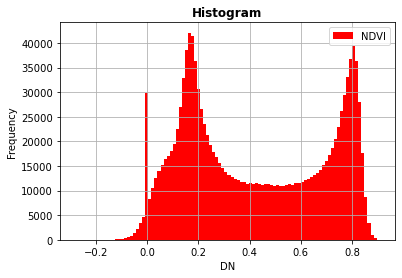

In [9]:
show_hist(ndvi_aoi, bins=100, masked=False, title='Histogram', ax=None, label='NDVI')

### Crop the extent of the Corine Land Cover 2018 (CLC 2018) to the AOI and display



In [10]:
#path to Corine land cover 2018
land_cover_dir = Path(os.path.join(download_dir_path,'u2018_clc2018_v2020_20u1_raster100m/DATA/'))
legend_dir = Path(os.path.join(download_dir_path,'u2018_clc2018_v2020_20u1_raster100m/Legend/'))
#path to the colormap
txt_filename = legend_dir/'CLC2018_CLC2018_V2018_20_QGIS.txt'

#### Re-project vector files to the same coordinate system of the CLC 2018

In [11]:
aoi_proj = aoi.to_crs(epsg=3035) # EPSG:3035 (ETRS89-extended / LAEA Europe)

#### Write CLC 2018 subset

In [12]:
with rio.open(str(land_cover_dir)+'/U2018_CLC2018_V2020_20u1.tif') as src:
    out_image, out_transform = mask(src, aoi_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "dtype": "int8",
                 "nodata":0
                    })
    
with rio.open("CLC_masked/Corine_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [13]:
### Create colorbar
def parse_line(line):
    _, r, g, b, a, descr = line.split(',')
    return (int(r), int(g), int(b), int(a)), descr.split('\n')[0]

with open(txt_filename, 'r') as txtf:
    lines = txtf.readlines()

legend = {nline+1: parse_line(line) for nline, line in enumerate(lines[:-1])}
legend[0] = parse_line(lines[-1])

#### Read CLC 2018 legend

In [14]:
classes_list = []
for k, v in sorted(legend.items()):
    print(f'{k}:\t{v[1]}')

0:	NODATA
1:	Continuous urban fabric
2:	Discontinuous urban fabric
3:	Industrial or commercial units
4:	Road and rail networks and associated land
5:	Port areas
6:	Airports
7:	Mineral extraction sites
8:	Dump sites
9:	Construction sites
10:	Green urban areas
11:	Sport and leisure facilities
12:	Non-irrigated arable land
13:	Permanently irrigated land
14:	Rice fields
15:	Vineyards
16:	Fruit trees and berry plantations
17:	Olive groves
18:	Pastures
19:	Annual crops associated with permanent crops
20:	Complex cultivation patterns
21:	Land principally occupied by agriculture with significant areas of natural vegetation
22:	Agro-forestry areas
23:	Broad-leaved forest
24:	Coniferous forest
25:	Mixed forest
26:	Natural grasslands
27:	Moors and heathland
28:	Sclerophyllous vegetation
29:	Transitional woodland-shrub
30:	Beaches dunes sands
31:	Bare rocks
32:	Sparsely vegetated areas
33:	Burnt areas
34:	Glaciers and perpetual snow
35:	Inland marshes
36:	Peat bogs
37:	Salt marshes
38:	Salines
39:

#### CLC 2018 in the area of interest

In [15]:
cover_land = rio.open("CLC_masked/Corine_masked.tif")
for i, dtype, nodataval in zip(cover_land.indexes, cover_land.dtypes, cover_land.nodatavals):
    print(i, dtype, nodataval)

array_rast = cover_land.read(1)

1 int8 0.0


In [16]:
#Set no data value to 0
array_rast[array_rast == -128] = 0

In [17]:
class_aoi = list(np.unique(array_rast))
legend_aoi = dict((k, legend[k]) for k in class_aoi if k in legend)

In [18]:
classes_list =[]
number_list = []
for k, v in sorted(legend_aoi.items()):
    #print(f'{k}:\t{v[1]}')
    classes_list.append(v[1])
    number_list.append(k)

class_dict = dict(zip(classes_list,number_list))

In [19]:
#create the colobar
corine_cmap_aoi= ListedColormap([np.array(v[0]).astype(float)/255.0 for k, v in sorted(legend_aoi.items())])

In [20]:
# Map the values in [0, 22]
new_dict = dict()
for i, v in enumerate(class_dict.items()):
    new_dict[v[1]] = (v[0], i)

fun = lambda x : new_dict[x][1]
matrix = map(np.vectorize(fun), array_rast)
matrix = np.matrix(list(matrix))

[Text(0.5, 1.0, 'Copernicus Corine land cover 2018')]

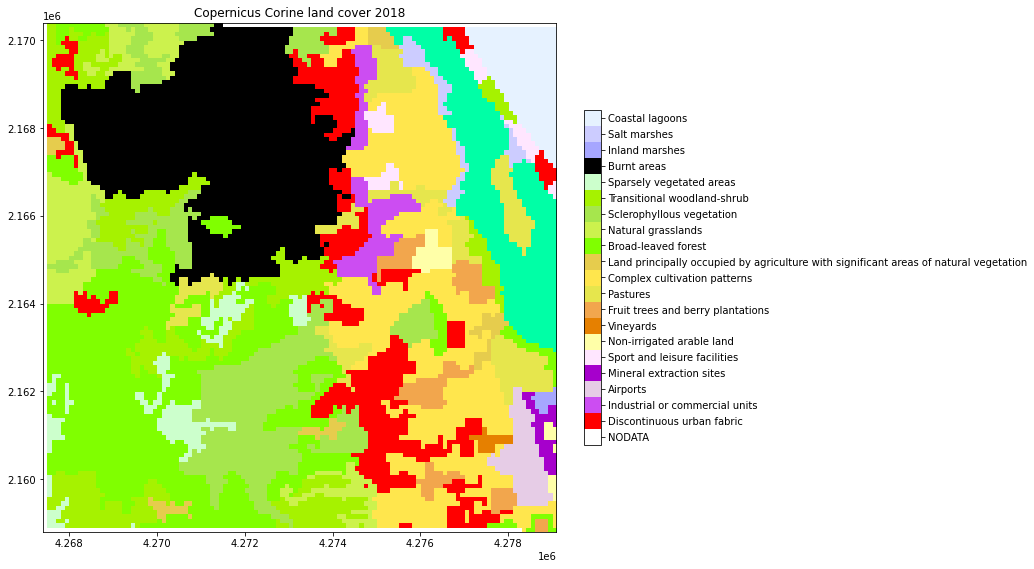

In [21]:
#plot
fig2, axs2 = plt.subplots(figsize=(10,10),sharey=True)
show(matrix, ax=axs2, cmap=corine_cmap_aoi, transform = cover_land.transform)
norm = colors.BoundaryNorm(np.arange(corine_cmap_aoi.N), corine_cmap_aoi.N)
cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=corine_cmap_aoi), ax=axs2, fraction=0.03)
cb.set_ticks([x+.5 for x in range(-1,22)]) # move the marks to the middle
cb.set_ticklabels(list(class_dict.keys())) # label the colors
axs2.set(title="Copernicus Corine land cover 2018")


### NDVI index on a burnt area and on a cultivation pattern area

In [22]:
#Load shapefile of the AOIs

burnt_zoom = gpd.read_file(os.path.join(path_shp, 'burnt_area_zoom.shp'))
cult_zoom = gpd.read_file(os.path.join(path_shp, 'complex_cultivation_patterns_zoom.shp'))

#### Crop the extent of the NDVI image to the AOIs

In [23]:
with rio.open(os.path.join(data_path, "S2_NDVI.tif")) as src:
    out_image, out_transform = mask(src, burnt_zoom.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open(os.path.join(data_path, "NDVI_burnt_area.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

In [24]:
with rio.open(os.path.join(data_path, "S2_NDVI.tif")) as src:
    out_image, out_transform = mask(src, cult_zoom.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rio.open(os.path.join(data_path, "NDVI_cultivation_area.tif"), "w", **out_meta) as dest:
    dest.write(out_image.astype(rio.float32))

##### Display NDVI index on the AOIs

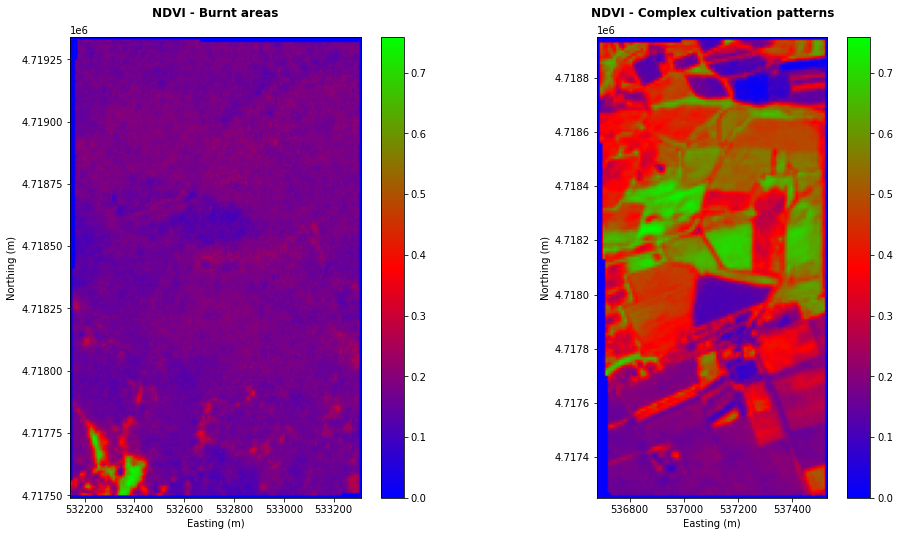

In [25]:
rcParams['axes.titlepad'] = 20 
src_burnt = rio.open(os.path.join(data_path, "NDVI_burnt_area.tif"))
src_cult = rio.open(os.path.join(data_path, "NDVI_cultivation_area.tif"))

fig, (axr, axg) = plt.subplots(1,2, figsize=(25, 8))

image_hidden_1 = axr.imshow(src_burnt.read(1), 
                         cmap='brg')

show(src_burnt, ax=axr, cmap='brg', transform=src_burnt.transform, title='NDVI - Burnt areas')
show(src_cult, ax=axg, cmap='brg', transform=src_cult.transform, title='NDVI - Complex cultivation patterns')

fig.colorbar(image_hidden_1, ax=axr)
fig.colorbar(image_hidden_1, ax=axg)
axr.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
axr.set_xlabel("Easting (m)")
axg.set_ylabel("Northing (m)") #(WGS 84 / UTM zone 32N)
axg.set_xlabel("Easting (m)")

plt.subplots_adjust(bottom=0.1, right=0.6, top=0.9)
#ttl = axr.title
#ttl.set_position([.5, 1.05])